In [1]:
#importing libraries
import pandas as pd
import nltk 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
import re 

In [2]:
#Reading the trainig data
data = pd.read_csv('C:\\Users\\warnak\\OneDrive - John Keells Holdings PLC\\workspace\\msc\\ML\\train.txt', sep='\t')

In [3]:
len(data)

3817

In [4]:
#reading the test data
test = pd.read_csv('C:\\Users\\warnak\\OneDrive - John Keells Holdings PLC\\workspace\\msc\\ML\\test.csv')

In [5]:
len(test)

784

# Pre-Processing steps

In [6]:
#combining the 2 datasets for preprocessing 
combi = data.append(test, ignore_index=True)

C:\Anaconda3\envs\msc_py35\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [7]:
#function to remove a given pattern in a string
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

In [8]:
#Removing mentions in tweets
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['Tweet text'], "@[\w]*")

In [9]:
#Removing special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [10]:
#Removing the which have less than 3 characters 
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [11]:
combi.head()

,Label,Tweet index,Tweet text,tidy_tweet
0,1.0,1,Sweet United Nations video. Just in time for C...,Sweet United Nations video Just time Christmas...
1,1.0,2,@mrdahl87 We are rumored to have talked to Erv...,rumored have talked agent Angels asked about E...
2,1.0,3,Hey there! Nice to see you Minnesota/ND Winter...,there Nice Minnesota Winter Weather #Not
3,0.0,4,3 episodes left I'm dying over here,episodes left dying over here
4,1.0,5,I can't breathe! was chosen as the most notabl...,breathe chosen most notable quote year annual ...


In [12]:
#tokenizing the tweets 
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Sweet, United, Nations, video, Just, time, Ch...
1    [rumored, have, talked, agent, Angels, asked, ...
2      [there, Nice, Minnesota, Winter, Weather, #Not]
3                  [episodes, left, dying, over, here]
4    [breathe, chosen, most, notable, quote, year, ...
Name: tidy_tweet, dtype: object

In [13]:
#Performing stemming 
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [sweet, unit, nation, video, just, time, chris...
1    [rumor, have, talk, agent, angel, ask, about, ...
2      [there, nice, minnesota, winter, weather, #not]
3                      [episod, left, die, over, here]
4    [breath, chosen, most, notabl, quot, year, ann...
Name: tidy_tweet, dtype: object

In [14]:
#adding the tokenized tweets 
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

# Word visualizations

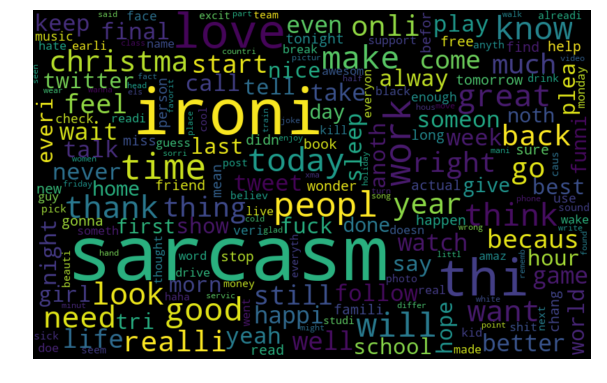

In [15]:
#Word visualizations
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

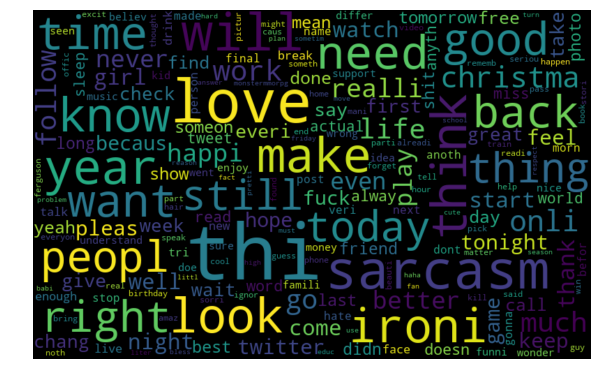

In [16]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['Label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

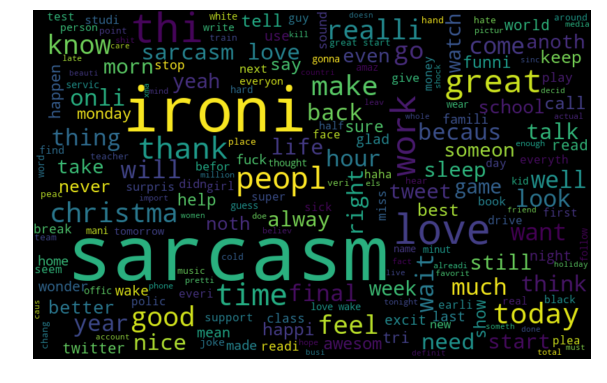

In [17]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['Label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [18]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [19]:
HT_nonIrony = hashtag_extract(combi['tidy_tweet'][combi['Label'] == 0])


HT_Irony = hashtag_extract(combi['tidy_tweet'][combi['Label'] == 1])


HT_nonIrony = sum(HT_nonIrony,[])
HT_Irony = sum(HT_Irony,[])

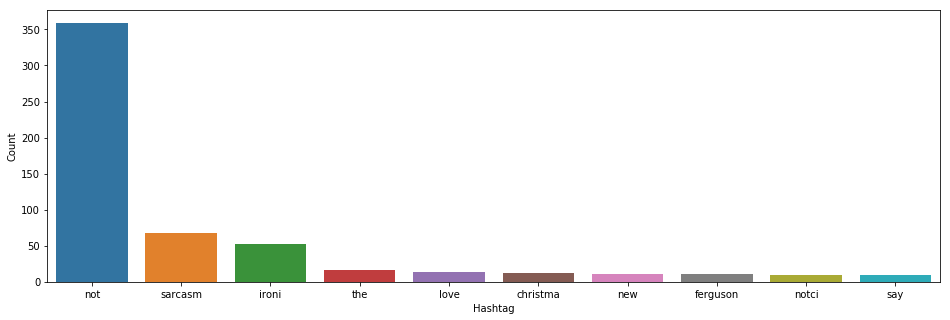

In [20]:
a = nltk.FreqDist(HT_nonIrony)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

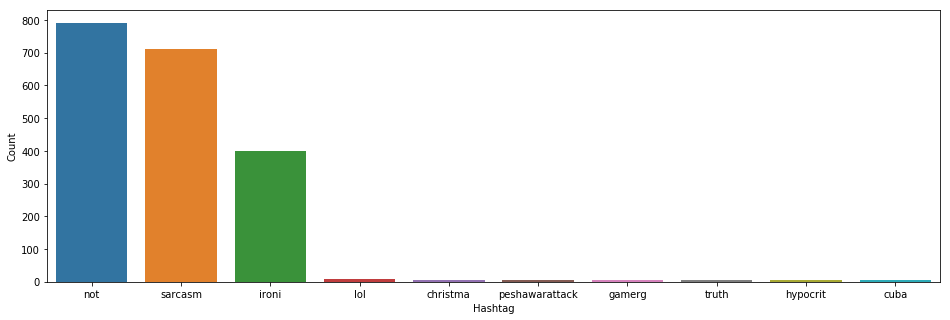

In [21]:
b = nltk.FreqDist(HT_Irony)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [22]:
#creating a bag of words
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

In [23]:
#creating a tfidf vector
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

# Model Building

In [24]:
#Logistic regression model using BOW as feature 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:3817,:]
test_bow = bow[3817:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, data['Label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.7840122982321291

# Getting the predictions

In [25]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['Label'] = test_pred_int

In [26]:
test.head()

,Tweet index,Tweet text,Label
0,1,@Callisto1947 Can U Help?||More conservatives ...,0
1,2,"Just walked in to #Starbucks and asked for a ""...",1
2,3,#NOT GONNA WIN http://t.co/Mc9ebqjAqj,0
3,4,@mickymantell He is exactly that sort of perso...,0
4,5,So much #sarcasm at work mate 10/10 #boring 10...,1


In [27]:
submission = test[['Tweet index','Label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file